In [1]:
import os
import dask
import math
import numpy as np
import pandas as pd
import seaborn as sns
import dask.dataframe as dd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from statsmodels.tsa.seasonal import seasonal_decompose
# Ignore harmless warnings
import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

In [2]:
df = pd.read_csv('./e_vm_instance.csv')
df['memory'] = df['memory']/1024
df['storage'] = df['storage']/1024
df = df.astype({'cores':str,'memory':str})
df['hw_1'] = df['cores'] + '-' + df['memory']
df.head()

,uuid,ali_uid,nc_name,ens_region_id,status,image_id,cores,memory,storage,os_type,os_name,start_time,end_time,hw_1
0,93c84b4ba1274e9bc8418a234bae88eb,52024,3b40776c97f7b5e7ff66e50a8d50512b,guangzhou-telecom,running,3193fad04c2288da16cda7e382b49e54,16,32.0,220.0,NaN,NaN,1581436800,1613059200,16-32.0
1,8dd1d92098806cf53bea24b6de5a893e,52024,92e3df7e56807493230fbf5264ff227d,guangzhou-telecom,running,3193fad04c2288da16cda7e382b49e54,16,32.0,220.0,NaN,NaN,1581436800,1613059200,16-32.0
2,1a8871ab9d19c0cdb2a3fa0fa4aa762c,84661,f59cba067775d60ce05786be6a8b2019,zhangjiagang-telecom,running,d03ca8d6a139b8174510898801989560,4,8.0,70.0,NaN,NaN,1511874666,1543334400,4-8.0
3,47942d3ce52ab46faba192464f7d26b4,52024,78186e4d3b85306f2a7fe69e9b6a3d1d,wuhan-telecom,running,47f1974d28a53acd0be37a18679c5ec6,16,32.0,220.0,NaN,NaN,1581436800,1613059200,16-32.0
4,48668a918cf0ce7c0fd92fb93a9792f6,52024,f580bc240290fd20cb752bf484248920,wuhan-telecom,running,47f1974d28a53acd0be37a18679c5ec6,16,32.0,220.0,NaN,NaN,1581436800,1613059200,16-32.0


In [3]:
len(df)

7410

In [4]:
cl = pd.read_csv('./instancePrice.csv')
cl.head()

,Unnamed: 0,region,system,network,isIO,instanceId,vCpu,memory,intranetGbps,intranetPPS,hourlyPrice,weeklyPrice,standard,monthlyPrice,yearlyPrice,2yearPrice,3yearPrice,4yearPrice,5yearPrice
0,0,cn-heyuan,windows,vpc,True,ecs.s6-c1m1.small,1,1.0,0.1,15,0.110,9.23,33.0,33.0,336.6,554.4,653.4,712.8,752.4
1,1,cn-heyuan,windows,vpc,True,ecs.s6-c1m2.small,1,2.0,0.1,15,0.210,16.79,60.0,60.0,612.0,1008.0,1188.0,1296.0,1368.0
2,2,cn-heyuan,windows,vpc,True,ecs.s6-c1m4.small,1,4.0,0.1,15,0.310,25.19,90.0,90.0,918.0,1512.0,1782.0,1944.0,2052.0
3,3,cn-heyuan,windows,vpc,True,ecs.t6-c2m1.large,2,1.0,0.08,6,0.059,4.75,17.0,17.0,173.4,285.6,336.6,367.2,387.6
4,4,cn-heyuan,windows,vpc,True,ecs.t6-c1m1.large,2,2.0,0.08,10,0.118,9.51,34.0,34.0,346.8,571.2,673.2,734.4,775.2


In [5]:
cl['region'].unique()

array(['cn-heyuan', 'cn-qingdao', 'cn-shanghai', 'cn-guangzhou',
       'cn-hangzhou', 'cn-shenzhen', 'cn-chengdu', 'cn-huhehaote',
       'cn-beijing', 'cn-wulanchabu', 'cn-zhangjiakou'], dtype=object)

In [6]:
cl = cl.astype({'vCpu':str,'memory':str})
cl['hw_1'] = cl['vCpu'] + '-' + cl['memory']
cl.head(10)

,Unnamed: 0,region,system,network,isIO,instanceId,vCpu,memory,intranetGbps,intranetPPS,hourlyPrice,weeklyPrice,standard,monthlyPrice,yearlyPrice,2yearPrice,3yearPrice,4yearPrice,5yearPrice,hw_1
0,0,cn-heyuan,windows,vpc,True,ecs.s6-c1m1.small,1,1.0,0.1,15,0.110,9.23,33.0,33.0,336.6,554.4,653.4,712.8,752.4,1-1.0
1,1,cn-heyuan,windows,vpc,True,ecs.s6-c1m2.small,1,2.0,0.1,15,0.210,16.79,60.0,60.0,612.0,1008.0,1188.0,1296.0,1368.0,1-2.0
2,2,cn-heyuan,windows,vpc,True,ecs.s6-c1m4.small,1,4.0,0.1,15,0.310,25.19,90.0,90.0,918.0,1512.0,1782.0,1944.0,2052.0,1-4.0
3,3,cn-heyuan,windows,vpc,True,ecs.t6-c2m1.large,2,1.0,0.08,6,0.059,4.75,17.0,17.0,173.4,285.6,336.6,367.2,387.6,2-1.0
4,4,cn-heyuan,windows,vpc,True,ecs.t6-c1m1.large,2,2.0,0.08,10,0.118,9.51,34.0,34.0,346.8,571.2,673.2,734.4,775.2,2-2.0
5,5,cn-heyuan,windows,vpc,True,ecs.t6-c1m2.large,2,4.0,0.08,10,0.236,19.03,68.0,68.0,693.6,1142.4,1346.4,1468.8,1550.4,2-4.0
6,6,cn-heyuan,windows,vpc,True,ecs.s6-c1m2.large,2,4.0,0.2,20,0.420,33.59,120.0,120.0,1224.0,2016.0,2376.0,2592.0,2736.0,2-4.0
7,7,cn-heyuan,windows,vpc,True,ecs.c6e.large,2,4.0,10,90,0.410,55.15,197.0,197.0,2009.4,3309.6,3900.6,4255.2,4491.6,2-4.0
8,8,cn-heyuan,windows,vpc,True,ecs.hfc6.large,2,4.0,1,30,0.448,60.19,215.0,215.0,2193.0,3612.0,4257.0,4644.0,4902.0,2-4.0
9,9,cn-heyuan,windows,vpc,True,ecs.c6.large,2,4.0,1,30,0.390,52.35,187.0,187.0,1907.4,3141.6,3702.6,4039.2,4263.6,2-4.0


In [7]:
#hcl = cl.groupby([cl['vCpu'],cl['memory']])[['monthlyPrice']].agg(lambda x:x.value_counts().index[0])
hcl = cl.groupby(cl['hw_1'])[['standard']].median()
hcl

,standard
hw_1,
1-0.5,18.00
1-1.0,33.00
1-2.0,80.00
1-4.0,141.00
1-8.0,249.00
10-46.0,2425.56
104-1536.0,24648.00
104-192.0,9724.00
104-384.0,12480.00


In [8]:
df=df.merge(hcl, left_on="hw_1",right_on="hw_1",how='left')
df

,uuid,ali_uid,nc_name,ens_region_id,status,image_id,cores,memory,storage,os_type,os_name,start_time,end_time,hw_1,standard
0,93c84b4ba1274e9bc8418a234bae88eb,52024,3b40776c97f7b5e7ff66e50a8d50512b,guangzhou-telecom,running,3193fad04c2288da16cda7e382b49e54,16,32.0,220.0,NaN,NaN,1581436800,1613059200,16-32.0,1576.0
1,8dd1d92098806cf53bea24b6de5a893e,52024,92e3df7e56807493230fbf5264ff227d,guangzhou-telecom,running,3193fad04c2288da16cda7e382b49e54,16,32.0,220.0,NaN,NaN,1581436800,1613059200,16-32.0,1576.0
2,1a8871ab9d19c0cdb2a3fa0fa4aa762c,84661,f59cba067775d60ce05786be6a8b2019,zhangjiagang-telecom,running,d03ca8d6a139b8174510898801989560,4,8.0,70.0,NaN,NaN,1511874666,1543334400,4-8.0,388.0
3,47942d3ce52ab46faba192464f7d26b4,52024,78186e4d3b85306f2a7fe69e9b6a3d1d,wuhan-telecom,running,47f1974d28a53acd0be37a18679c5ec6,16,32.0,220.0,NaN,NaN,1581436800,1613059200,16-32.0,1576.0
4,48668a918cf0ce7c0fd92fb93a9792f6,52024,f580bc240290fd20cb752bf484248920,wuhan-telecom,running,47f1974d28a53acd0be37a18679c5ec6,16,32.0,220.0,NaN,NaN,1581436800,1613059200,16-32.0,1576.0
5,e8c4d790557c1ea8cb1453f34d366879,52024,df29fde90ff2025820720f4a26ad8ab9,wuhan-telecom,running,47f1974d28a53acd0be37a18679c5ec6,16,32.0,220.0,NaN,NaN,1581436800,1613059200,16-32.0,1576.0
6,7e9f5aaee3a35fd6281b76a4f817172d,52024,7e82362604e14d216a229f720ec2e4b6,wuhan-telecom,running,47f1974d28a53acd0be37a18679c5ec6,16,32.0,220.0,NaN,NaN,1581436800,1613059200,16-32.0,1576.0
7,416800e129d3675be134d88ee24ba795,52024,05e6e219c2b260ad091ed420378bd113,guangzhou-telecom,running,47f1974d28a53acd0be37a18679c5ec6,16,32.0,220.0,NaN,NaN,1581436800,1613059200,16-32.0,1576.0
8,fc976bd41b0a779e7cfc698d998f3aee,52024,6812c1a96e2c0eba74043740a0ef288b,guangzhou-telecom,running,47f1974d28a53acd0be37a18679c5ec6,16,32.0,220.0,NaN,NaN,1581436800,1613059200,16-32.0,1576.0
9,1bca39eb8cb4568299043861462a9221,52024,3604806947a20c9d05c5bb52788dbdef,guangzhou-telecom,running,47f1974d28a53acd0be37a18679c5ec6,16,32.0,220.0,NaN,NaN,1581436800,1613059200,16-32.0,1576.0


In [9]:
df['hw_c'] = df['storage'] + df['standard']
df

,uuid,ali_uid,nc_name,ens_region_id,status,image_id,cores,memory,storage,os_type,os_name,start_time,end_time,hw_1,standard,hw_c
0,93c84b4ba1274e9bc8418a234bae88eb,52024,3b40776c97f7b5e7ff66e50a8d50512b,guangzhou-telecom,running,3193fad04c2288da16cda7e382b49e54,16,32.0,220.0,NaN,NaN,1581436800,1613059200,16-32.0,1576.0,1796.0
1,8dd1d92098806cf53bea24b6de5a893e,52024,92e3df7e56807493230fbf5264ff227d,guangzhou-telecom,running,3193fad04c2288da16cda7e382b49e54,16,32.0,220.0,NaN,NaN,1581436800,1613059200,16-32.0,1576.0,1796.0
2,1a8871ab9d19c0cdb2a3fa0fa4aa762c,84661,f59cba067775d60ce05786be6a8b2019,zhangjiagang-telecom,running,d03ca8d6a139b8174510898801989560,4,8.0,70.0,NaN,NaN,1511874666,1543334400,4-8.0,388.0,458.0
3,47942d3ce52ab46faba192464f7d26b4,52024,78186e4d3b85306f2a7fe69e9b6a3d1d,wuhan-telecom,running,47f1974d28a53acd0be37a18679c5ec6,16,32.0,220.0,NaN,NaN,1581436800,1613059200,16-32.0,1576.0,1796.0
4,48668a918cf0ce7c0fd92fb93a9792f6,52024,f580bc240290fd20cb752bf484248920,wuhan-telecom,running,47f1974d28a53acd0be37a18679c5ec6,16,32.0,220.0,NaN,NaN,1581436800,1613059200,16-32.0,1576.0,1796.0
5,e8c4d790557c1ea8cb1453f34d366879,52024,df29fde90ff2025820720f4a26ad8ab9,wuhan-telecom,running,47f1974d28a53acd0be37a18679c5ec6,16,32.0,220.0,NaN,NaN,1581436800,1613059200,16-32.0,1576.0,1796.0
6,7e9f5aaee3a35fd6281b76a4f817172d,52024,7e82362604e14d216a229f720ec2e4b6,wuhan-telecom,running,47f1974d28a53acd0be37a18679c5ec6,16,32.0,220.0,NaN,NaN,1581436800,1613059200,16-32.0,1576.0,1796.0
7,416800e129d3675be134d88ee24ba795,52024,05e6e219c2b260ad091ed420378bd113,guangzhou-telecom,running,47f1974d28a53acd0be37a18679c5ec6,16,32.0,220.0,NaN,NaN,1581436800,1613059200,16-32.0,1576.0,1796.0
8,fc976bd41b0a779e7cfc698d998f3aee,52024,6812c1a96e2c0eba74043740a0ef288b,guangzhou-telecom,running,47f1974d28a53acd0be37a18679c5ec6,16,32.0,220.0,NaN,NaN,1581436800,1613059200,16-32.0,1576.0,1796.0
9,1bca39eb8cb4568299043861462a9221,52024,3604806947a20c9d05c5bb52788dbdef,guangzhou-telecom,running,47f1974d28a53acd0be37a18679c5ec6,16,32.0,220.0,NaN,NaN,1581436800,1613059200,16-32.0,1576.0,1796.0


In [10]:
ecs_cpu = df.groupby(df['ali_uid'])[['hw_c']].sum()
ecs_cpu

,hw_c
ali_uid,
1775,4.280000e+02
2088,6.120000e+03
2766,5.718400e+04
4588,6.232240e+04
4939,1.000000e+02
5525,1.000000e+02
6224,2.709600e+04
7120,8.584000e+03
9004,3.757679e+04


In [11]:
col = ['uuid','ali_uid']
instance = pd.read_csv('./e_vm_instance.csv',usecols=col)

cols = ['ins_id','region_id','pub_down_bw','pub_up_bw','report_ts']
bw = dd.read_csv('../data/June-all/T_INSTANCE_BANDWIDTH/T_INSTANCE_BANDWIDTH.csv',usecols=cols)
bw = bw.compute()

bw=bw.merge(instance, left_on="ins_id",right_on="uuid")
bw.head(10)

,ins_id,region_id,pub_down_bw,pub_up_bw,report_ts,uuid,ali_uid
0,37ab60d379611b4f8388a8f99ea3e525,chengdu-cmcc,9614192,11400298,1593285900,37ab60d379611b4f8388a8f99ea3e525,2766
1,37ab60d379611b4f8388a8f99ea3e525,chengdu-cmcc,9717733,11521627,1593286200,37ab60d379611b4f8388a8f99ea3e525,2766
2,37ab60d379611b4f8388a8f99ea3e525,chengdu-cmcc,12493401,14613008,1593320400,37ab60d379611b4f8388a8f99ea3e525,2766
3,37ab60d379611b4f8388a8f99ea3e525,chengdu-cmcc,12735470,14871775,1593320700,37ab60d379611b4f8388a8f99ea3e525,2766
4,37ab60d379611b4f8388a8f99ea3e525,chengdu-cmcc,22511387,26258769,1593355200,37ab60d379611b4f8388a8f99ea3e525,2766
5,37ab60d379611b4f8388a8f99ea3e525,chengdu-cmcc,3658752,4263962,1593389700,37ab60d379611b4f8388a8f99ea3e525,2766
6,37ab60d379611b4f8388a8f99ea3e525,chengdu-cmcc,3583635,4154022,1593390000,37ab60d379611b4f8388a8f99ea3e525,2766
7,37ab60d379611b4f8388a8f99ea3e525,chengdu-cmcc,8179721,9294605,1593424500,37ab60d379611b4f8388a8f99ea3e525,2766
8,37ab60d379611b4f8388a8f99ea3e525,chengdu-cmcc,6873413,8283883,1593459000,37ab60d379611b4f8388a8f99ea3e525,2766
9,37ab60d379611b4f8388a8f99ea3e525,chengdu-cmcc,6184013,7450185,1593459300,37ab60d379611b4f8388a8f99ea3e525,2766


In [51]:
import math
def bw_c4(x):
    if(x <= 5):
        return 23*math.ceil(x)
    else:
        return 115+80*(math.ceil(x)-5)

In [52]:
bw4_record = pd.DataFrame(columns=["ali_uid","ins_id","bw_c4"])
n=0
for i in bw['ali_uid'].unique():
    ali_u = bw[bw["ali_uid"]== i].copy()
    
    ali_u['date'] = pd.to_datetime(ali_u['report_ts'],unit='s')
    ali_u['date'] = pd.DatetimeIndex(ali_u['date']) + timedelta(hours=8)
    bw_ins = ali_u.groupby([ali_u['ins_id'],ali_u['date']])[['pub_up_bw','pub_down_bw']].mean()

    for j in bw_ins.index.levels[0]:
        df4 = bw_ins.loc[j].resample('M').max()
        df4['max']=df4[["pub_up_bw", "pub_down_bw"]].max(axis=1)
        #所有日峰值带宽降序排列，取第四大的日峰值带宽作为计费带宽
        df4['max']=df4['max']/1000000
        df4['bw_4'] = df4['max'].map(bw_c4)
        cost = sum(df4['bw_4'])
        new = pd.DataFrame({"ali_uid":i,"ins_id":j,"bw_c4":cost},index=["0"])
        bw4_record = bw4_record.append(new,ignore_index=True)
    
    n=n+1
    if(n%10==0):
        print("%d aliusers has been processed"%(n))

10 aliusers has been processed
20 aliusers has been processed
30 aliusers has been processed
40 aliusers has been processed
50 aliusers has been processed
60 aliusers has been processed
70 aliusers has been processed
80 aliusers has been processed
90 aliusers has been processed
100 aliusers has been processed
110 aliusers has been processed
120 aliusers has been processed
130 aliusers has been processed


In [53]:
ecs_bw4 = bw4_record.groupby(bw4_record['ali_uid'])[['bw_c4']].sum()
ecs_bw4

,bw_c4
ali_uid,
1775,23
2088,4079
2766,317343
4588,260460
6224,22465
7120,10665
9004,538
9682,23
10812,23


In [54]:
ecs_bw4.sort_values(by='bw_c4',ascending=False,inplace=True)
ecs_bw4.to_csv('./bw4.csv')

In [55]:
ecs_bw4

,bw_c4
ali_uid,
64389,52402964
98051,23731503
78131,12730775
66394,12274369
48944,6888368
22399,6036885
64892,5010008
19570,4613358
25295,3200459


In [15]:
import math
def bw_c1(x):
    if(x <= 1):
        return 23
    elif x<=2:
        return 46
    elif x<=3:
        return 71
    elif x<=4:
        return 96
    elif x<=5:
        return 125
    else:
        return 125+80*(math.ceil(x)-5)

In [16]:
bw1_record = pd.DataFrame(columns=["ali_uid","ins_id","bw_c1"])
n=0
for i in bw['ali_uid'].unique():
    ali_u = bw[bw["ali_uid"]== i].copy()
    
    ali_u['date'] = pd.to_datetime(ali_u['report_ts'],unit='s')
    ali_u['date'] = pd.DatetimeIndex(ali_u['date']) + timedelta(hours=8)
    bw_ins = ali_u.groupby([ali_u['ins_id'],ali_u['date']])[['pub_up_bw','pub_down_bw']].mean()

    for j in bw_ins.index.levels[0]:
        df1 = bw_ins.loc[j].resample('M').max()
        df1['max']=df1[["pub_up_bw", "pub_down_bw"]].max(axis=1)
        df1['max']=df1['max']/1000000
        df1['bw_1'] = df1['max'].map(bw_c1)
        cost = sum(df1['bw_1'])
        new = pd.DataFrame({"ali_uid":i,"ins_id":j,"bw_c1":cost},index=["0"])
        bw1_record = bw1_record.append(new,ignore_index=True)
    
    n=n+1
    if(n%10==0):
        print("%d aliusers has been processed"%(n))

10 aliusers has been processed
20 aliusers has been processed
30 aliusers has been processed
40 aliusers has been processed
50 aliusers has been processed
60 aliusers has been processed
70 aliusers has been processed
80 aliusers has been processed
90 aliusers has been processed
100 aliusers has been processed
110 aliusers has been processed
120 aliusers has been processed
130 aliusers has been processed


In [17]:
bw1_record

,ali_uid,ins_id,bw_c1
0,2766,02655b9a9861fab07ebe50af5675732c,5187.5
1,2766,0daa66a7a2bd1100ed063c6870997ee2,3157.5
2,2766,13d7c2ae3f7b8b42d518d55776ef0021,3520.0
3,2766,16b644be9bc95110e19d8957e867af49,2940.0
4,2766,17e3b1f3a6075ee8eec40ff4cdb401c9,4897.5
5,2766,1b291f70036ffaeef3efa612ac9af618,2360.0
6,2766,1c88441137d635148c159c332a459499,5260.0
7,2766,33d7e7f9c1d87c77413c004cf84079db,4680.0
8,2766,3572fabda1f342bedc6e9855c9f323f8,5187.5
9,2766,37ab60d379611b4f8388a8f99ea3e525,3447.5


In [18]:
ecs_bw1 = bw1_record.groupby(bw1_record['ali_uid'])[['bw_c1']].sum()
ecs_bw1

,bw_c1
ali_uid,
1775,20.7
2088,3813.9
2766,288188.2
4588,236285.8
6224,20360.0
7120,9681.0
9004,495.7
9682,20.7
10812,20.7


In [65]:
def bw_c5(x):
    if(x <= 5.0):
        return 0.063*x
    else:
        return 0.315+0.25*(x-5.0)

In [66]:
bw5_record = pd.DataFrame(columns=["ali_uid","ins_id","bw_c5"])
n=0
for i in bw['ali_uid'].unique():
    ali_u = bw[bw["ali_uid"]== i].copy()
    
    ali_u['date'] = pd.to_datetime(ali_u['report_ts'],unit='s')
    ali_u['date'] = pd.DatetimeIndex(ali_u['date']) + timedelta(hours=8)
    bw_ins = ali_u.groupby([ali_u['ins_id'],ali_u['date']])[['pub_up_bw','pub_down_bw']].mean()

    for j in bw_ins.index.levels[0]:
        df5 = bw_ins.loc[j].resample('H').max()
        df5['max']=df5[["pub_up_bw", "pub_down_bw"]].max(axis=1)
        df5['max']=df5['max']/1000000
        df5['bw'] = df5['max'].map(bw_c5)
        cost = sum(df5['bw'])
    
        new = pd.DataFrame({"ali_uid":i,"ins_id":j,"bw_c5":cost},index=["0"])
        bw5_record = bw5_record.append(new,ignore_index=True)
    
    n=n+1
    if(n%10==0):
        print("%d aliusers has been processed"%(n))

10 aliusers has been processed
20 aliusers has been processed
30 aliusers has been processed
40 aliusers has been processed
50 aliusers has been processed
60 aliusers has been processed
70 aliusers has been processed
80 aliusers has been processed
90 aliusers has been processed
100 aliusers has been processed
110 aliusers has been processed
120 aliusers has been processed
130 aliusers has been processed


In [67]:
ecs_bw5 = bw5_record.groupby(bw5_record['ali_uid'])[['bw_c5']].sum()
ecs_bw5.sort_values(by='bw_c5',ascending=False,inplace=True)
ecs_bw5.to_csv('./bw5.csv')

In [68]:
ecs_bw5

,bw_c5
ali_uid,
64389,4.090457e+07
98051,1.245179e+07
48944,6.475810e+06
66394,6.427828e+06
22399,3.907695e+06
31102,2.459684e+06
52024,1.442325e+06
78131,1.252277e+06
25295,9.326895e+05


In [29]:
def bw_c2(x):
    if(x <= 5.0):
        return 0.063*x
    else:
        return 0.315+0.248*(x-5.0)

In [30]:
bw2_record = pd.DataFrame(columns=["ali_uid","ins_id","bw_c2"])
n=0
for i in bw['ali_uid'].unique():
    ali_u = bw[bw["ali_uid"]== i].copy()
    
    ali_u['date'] = pd.to_datetime(ali_u['report_ts'],unit='s')
    ali_u['date'] = pd.DatetimeIndex(ali_u['date']) + timedelta(hours=8)
    bw_ins = ali_u.groupby([ali_u['ins_id'],ali_u['date']])[['pub_up_bw','pub_down_bw']].mean()

    for j in bw_ins.index.levels[0]:
        df2 = bw_ins.loc[j].resample('H').max()
        df2['max']=df2[["pub_up_bw", "pub_down_bw"]].max(axis=1)
        df2['max']=df2['max']/1000000
        df2['bw'] = df2['max'].map(bw_c2)
        cost = sum(df2['bw'])
    
        new = pd.DataFrame({"ali_uid":i,"ins_id":j,"bw_c2":cost},index=["0"])
        bw2_record = bw2_record.append(new,ignore_index=True)
    
    n=n+1
    if(n%10==0):
        print("%d aliusers has been processed"%(n))

10 aliusers has been processed
20 aliusers has been processed
30 aliusers has been processed
40 aliusers has been processed
50 aliusers has been processed
60 aliusers has been processed
70 aliusers has been processed
80 aliusers has been processed
90 aliusers has been processed
100 aliusers has been processed
110 aliusers has been processed
120 aliusers has been processed
130 aliusers has been processed


In [31]:
bw2_record

,ali_uid,ins_id,bw_c2
0,2766,02655b9a9861fab07ebe50af5675732c,4582.697325
1,2766,0daa66a7a2bd1100ed063c6870997ee2,2313.545087
2,2766,13d7c2ae3f7b8b42d518d55776ef0021,2976.747312
3,2766,16b644be9bc95110e19d8957e867af49,2276.471646
4,2766,17e3b1f3a6075ee8eec40ff4cdb401c9,4460.076323
5,2766,1b291f70036ffaeef3efa612ac9af618,2623.773155
6,2766,1c88441137d635148c159c332a459499,5016.159725
7,2766,33d7e7f9c1d87c77413c004cf84079db,2652.798587
8,2766,3572fabda1f342bedc6e9855c9f323f8,4978.292236
9,2766,37ab60d379611b4f8388a8f99ea3e525,2156.504757


In [32]:
ecs_bw2 = bw2_record.groupby(bw2_record['ali_uid'])[['bw_c2']].sum()
ecs_bw2

,bw_c2
ali_uid,
1775,1.248532e+00
2088,1.551018e+01
2766,2.578507e+05
4588,3.634206e+05
6224,1.451303e+02
7120,8.726591e+03
9004,2.659641e+01
9682,1.019700e-01
10812,1.202319e+00


In [69]:
bw6_record = pd.DataFrame(columns=["ali_uid","ins_id","bw_c6"])
n=0
for i in bw['ali_uid'].unique():
    ali_u = bw[bw["ali_uid"]== i].copy()
    
    ali_u['date'] = pd.to_datetime(ali_u['report_ts'],unit='s')
    ali_u['date'] = pd.DatetimeIndex(ali_u['date']) + timedelta(hours=8)
    bw_ins = ali_u.groupby([ali_u['ins_id'],ali_u['date']])[['pub_up_bw','pub_down_bw']].mean()

    for j in bw_ins.index.levels[0]:        
        df6 = bw_ins.loc[j].resample('D').sum()
        df6['bw']=df6["pub_up_bw"]+ df6["pub_down_bw"]
        cost = sum(df6['bw'])*0.8*300/(8*1024*1024*1024)
        new = pd.DataFrame({"ali_uid":i,"ins_id":j,"bw_c6":cost},index=["0"])
        bw6_record = bw6_record.append(new,ignore_index=True)
    
    n=n+1
    if(n%10==0):
        print("%d aliusers has been processed"%(n))

10 aliusers has been processed
20 aliusers has been processed
30 aliusers has been processed
40 aliusers has been processed
50 aliusers has been processed
60 aliusers has been processed
70 aliusers has been processed
80 aliusers has been processed
90 aliusers has been processed
100 aliusers has been processed
110 aliusers has been processed
120 aliusers has been processed
130 aliusers has been processed


In [70]:
ecs_bw6 = bw6_record.groupby(bw6_record['ali_uid'])[['bw_c6']].sum()
ecs_bw6.sort_values(by='bw_c6',ascending=False,inplace=True)
ecs_bw6.to_csv('./bw6.csv')

In [71]:
ecs_bw6

,bw_c6
ali_uid,
64389,7.101415e+07
98051,2.046861e+07
48944,1.510564e+07
66394,1.340730e+07
22399,7.035508e+06
31102,4.646390e+06
52024,3.675211e+06
77787,1.965134e+06
25295,1.197954e+06


In [33]:
bw3_record = pd.DataFrame(columns=["ali_uid","ins_id","bw_c3"])
n=0
for i in bw['ali_uid'].unique():
    ali_u = bw[bw["ali_uid"]== i].copy()
    
    ali_u['date'] = pd.to_datetime(ali_u['report_ts'],unit='s')
    ali_u['date'] = pd.DatetimeIndex(ali_u['date']) + timedelta(hours=8)
    bw_ins = ali_u.groupby([ali_u['ins_id'],ali_u['date']])[['pub_up_bw','pub_down_bw']].mean()

    for j in bw_ins.index.levels[0]:        
        df3 = bw_ins.loc[j].resample('D').sum()
        df3['bw']=df3["pub_up_bw"]+ df3["pub_down_bw"]
        cost = sum(df3['bw'])*0.72*300/(8*1024*1024*1024)
        new = pd.DataFrame({"ali_uid":i,"ins_id":j,"bw_c3":cost},index=["0"])
        bw3_record = bw3_record.append(new,ignore_index=True)
    
    n=n+1
    if(n%10==0):
        print("%d aliusers has been processed"%(n))

10 aliusers has been processed
20 aliusers has been processed
30 aliusers has been processed
40 aliusers has been processed
50 aliusers has been processed
60 aliusers has been processed
70 aliusers has been processed
80 aliusers has been processed
90 aliusers has been processed
100 aliusers has been processed
110 aliusers has been processed
120 aliusers has been processed
130 aliusers has been processed


In [34]:
bw3_record

,ali_uid,ins_id,bw_c3
0,2766,02655b9a9861fab07ebe50af5675732c,10690.822767
1,2766,0daa66a7a2bd1100ed063c6870997ee2,5953.371642
2,2766,13d7c2ae3f7b8b42d518d55776ef0021,7386.491439
3,2766,16b644be9bc95110e19d8957e867af49,5916.933402
4,2766,17e3b1f3a6075ee8eec40ff4cdb401c9,10042.574933
5,2766,1b291f70036ffaeef3efa612ac9af618,6736.485302
6,2766,1c88441137d635148c159c332a459499,11630.223508
7,2766,33d7e7f9c1d87c77413c004cf84079db,6541.399220
8,2766,3572fabda1f342bedc6e9855c9f323f8,11521.256297
9,2766,37ab60d379611b4f8388a8f99ea3e525,5452.564616


In [35]:
ecs_bw3 = bw3_record.groupby(bw3_record['ali_uid'])[['bw_c3']].sum()
ecs_bw3

,bw_c3
ali_uid,
1775,5.687773e+00
2088,2.913871e+01
2766,6.136896e+05
4588,4.297746e+05
6224,4.191482e+02
7120,1.166156e+04
9004,1.192270e+02
9682,1.664677e-01
10812,4.989522e+00


In [36]:
ecs_bw1.sort_values(by='bw_c1',ascending=False,inplace=True)

In [37]:
ecs_bw1

,bw_c1
ali_uid,
64389,47492406.7
98051,21512186.9
78131,11538830.0
66394,11126445.9
48944,6243999.1
22399,5471771.0
64892,4540925.6
19570,4182074.0
25295,2900697.1


In [38]:
ecs_bw2.sort_values(by='bw_c2',ascending=False,inplace=True)
ecs_bw2

,bw_c2
ali_uid,
64389,4.057776e+07
98051,1.235298e+07
48944,6.424294e+06
66394,6.376940e+06
22399,3.876602e+06
31102,2.440172e+06
52024,1.431436e+06
78131,1.242441e+06
25295,9.252891e+05


In [39]:
ecs_bw3.sort_values(by='bw_c3',ascending=False,inplace=True)
ecs_bw3

,bw_c3
ali_uid,
64389,6.391273e+07
98051,1.842175e+07
48944,1.359508e+07
66394,1.206657e+07
22399,6.331957e+06
31102,4.181751e+06
52024,3.307690e+06
77787,1.768620e+06
25295,1.078159e+06


In [41]:
ecs_bw1.to_csv('./bw1.csv')
ecs_bw2.to_csv('./bw2.csv')
ecs_bw3.to_csv('./bw3.csv')

In [73]:
ecs_bw4=pd.read_csv('./bw4.csv')
ecs_bw5=pd.read_csv('./bw5.csv')
ecs_bw6=pd.read_csv('./bw6.csv')

In [74]:
ali_u = [64389,98051,78131,66394,48944,52024,80365,22399,31102,77787,64892,15301,83822,25295,13404]
bww4 = ecs_bw4[ecs_bw4['ali_uid'].isin(ali_u)]
bww5 = ecs_bw5[ecs_bw5['ali_uid'].isin(ali_u)]
bww6 = ecs_bw6[ecs_bw6['ali_uid'].isin(ali_u)]

In [75]:
v4 = list(bww4['bw_c4']*0.15)
v5 = list(bww5['bw_c5']*0.15)
v6 = list(bww6['bw_c6']*0.15)

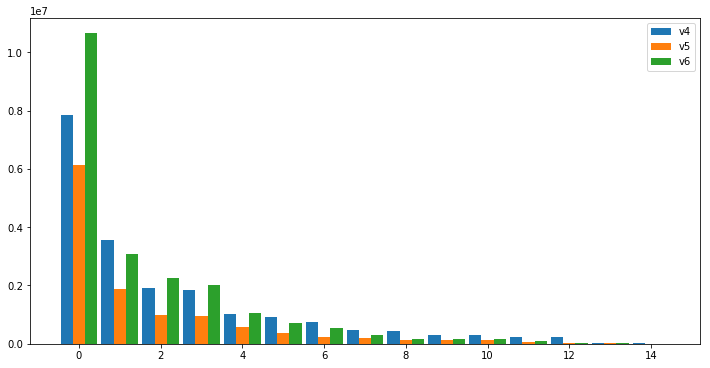

In [76]:
x = np.arange(len(ali_u))  # the label locations
width = 0.3  # the width of the bars

fig, ax = plt.subplots(figsize=(12,6))
ax.bar(x - width, v4, width, label='v4')
ax.bar(x, v5, width, label='v5')
ax.bar(x + width, v6, width, label='v6')


ax.legend()

In [56]:
ecs_bw1=pd.read_csv('./bw1.csv')
ecs_bw2=pd.read_csv('./bw2.csv')
ecs_bw3=pd.read_csv('./bw3.csv')
ecs_bw4=pd.read_csv('./bw4.csv')

In [57]:
ali_u = [64389,98051,78131,66394,48944,52024,80365,22399,31102,77787,64892,15301,83822,25295,13404]
bww1 = ecs_bw1[ecs_bw1['ali_uid'].isin(ali_u)]
bww2 = ecs_bw2[ecs_bw2['ali_uid'].isin(ali_u)]
bww3 = ecs_bw3[ecs_bw3['ali_uid'].isin(ali_u)]
bww4 = ecs_bw4[ecs_bw4['ali_uid'].isin(ali_u)]

In [58]:
v1 = list(bww1['bw_c1']*0.15)
v2 = list(bww2['bw_c2']*0.15)
v3 = list(bww3['bw_c3']*0.15)
v4 = list(bww4['bw_c4']*0.15)

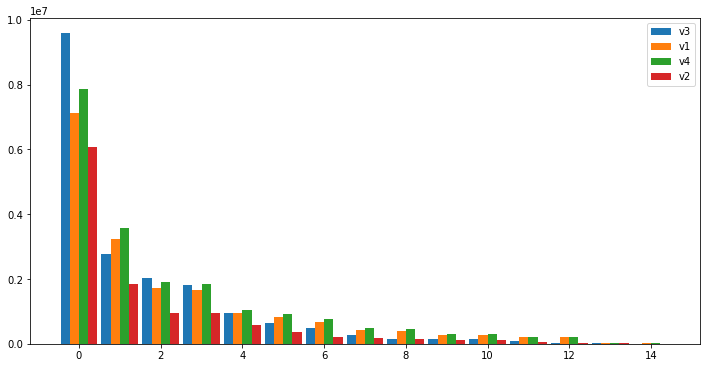

In [59]:
x = np.arange(len(ali_u))  # the label locations
width = 0.225  # the width of the bars

fig, ax = plt.subplots(figsize=(12,6))
ax.bar(x - 1.5*width, v3, width, label='v3')
ax.bar(x - 0.5*width, v1, width, label='v1')
ax.bar(x + 0.5*width, v4, width, label='v4')
ax.bar(x + 1.5*width, v2, width, label='v2')

ax.legend()

In [60]:
ens_cost=pd.read_csv("./ENS_aliu_cost.csv")
ens_cost.head(20)
bww5 = ens_cost[ens_cost['ali_uid'].isin(ali_u)]

In [61]:
bww5

,ali_uid,hw_c,bw_c,ens_cost
0,64389,2.269956e+06,1.398799e+07,1.625795e+07
1,98051,2.561929e+06,3.807377e+06,6.369306e+06
2,78131,6.678000e+05,2.396274e+06,3.064074e+06
3,66394,1.164135e+06,1.775225e+06,2.939360e+06
4,48944,3.220525e+05,1.401616e+06,1.723668e+06
5,52024,9.713760e+05,4.846352e+05,1.456011e+06
6,80365,1.350524e+06,2.452629e+03,1.352977e+06
7,22399,1.879990e+05,9.711554e+05,1.159154e+06
8,31102,2.915325e+05,6.158246e+05,9.073571e+05
9,77787,3.306590e+05,3.860114e+05,7.166704e+05


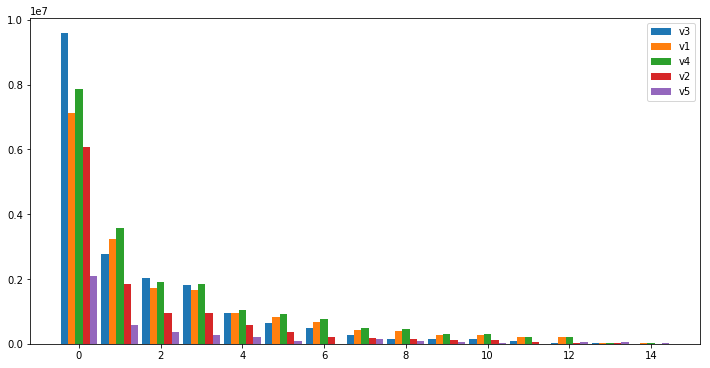

In [62]:
v5 = list(bww5['bw_c']*0.15)
x = np.arange(len(ali_u))  # the label locations
width = 0.18 # the width of the bars

fig, ax = plt.subplots(figsize=(12,6))
ax.bar(x - 2*width, v3, width, label='v3')
ax.bar(x -width, v1, width, label='v1')
ax.bar(x , v4, width, label='v4')
ax.bar(x + width, v2, width, label='v2')
ax.bar(x + 2*width, v5, width, label='v5')

ax.legend()

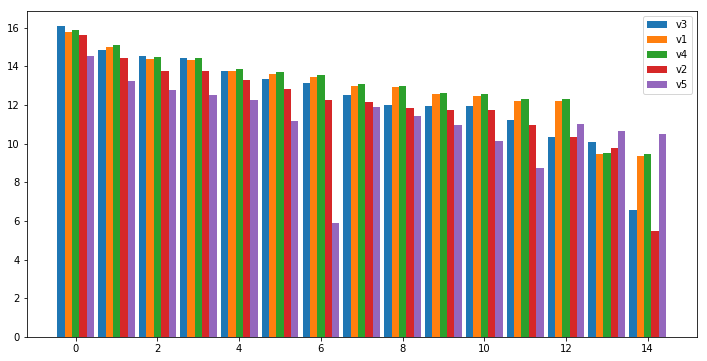

In [63]:
v1 = list(np.log(bww1['bw_c1']*0.15))
v2 = list(np.log(bww2['bw_c2']*0.15))
v3 = list(np.log(bww3['bw_c3']*0.15))
v4 = list(np.log(bww4['bw_c4']*0.15))
v5 = list(np.log(bww5['bw_c']*0.15))
x = np.arange(len(ali_u))  # the label locations
width = 0.18 # the width of the bars

fig, ax = plt.subplots(figsize=(12,6))
ax.bar(x - 2*width, v3, width, label='v3')
ax.bar(x -width, v1, width, label='v1')
ax.bar(x , v4, width, label='v4')
ax.bar(x + width, v2, width, label='v2')
ax.bar(x + 2*width, v5, width, label='v5')

ax.legend()

In [18]:
ecs_bw.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 137 entries, 1775 to 99553
Data columns (total 1 columns):
bw_c    137 non-null float64
dtypes: float64(1)
memory usage: 2.1 KB


In [19]:
ecs_cost=pd.merge(ecs_cpu,ecs_bw, left_on="ali_uid",right_on="ali_uid")
ecs_cost

,hw_c,bw_c
ali_uid,,
1775,4.280000e+02,1.194968e+01
2088,6.120000e+03,7.915226e+01
2766,5.718400e+04,3.234577e+06
4588,6.232240e+04,4.047948e+06
6224,2.709600e+04,8.378492e+02
7120,8.584000e+03,1.045594e+05
9004,3.757679e+04,2.552211e+02
9682,1.200000e+02,3.523678e-01
10812,1.000000e+02,1.102440e+01


In [20]:
ecs_cost['cost']=ecs_cost['hw_c']+ecs_cost['bw_c']
ecs_cost.sort_values(by='cost',ascending=False,inplace=True)
ecs_cost

,hw_c,bw_c,cost
ali_uid,,,
64389,1.848154e+06,4.041692e+08,4.060174e+08
98051,2.574172e+06,1.239145e+08,1.264886e+08
48944,3.055340e+05,6.806997e+07,6.837550e+07
66394,1.200952e+06,6.259009e+07,6.379104e+07
22399,1.921720e+05,3.758637e+07,3.777854e+07
31102,3.063924e+05,2.756769e+07,2.787409e+07
52024,9.634120e+05,1.678005e+07,1.774346e+07
25295,1.945160e+05,1.047332e+07,1.066784e+07
77787,3.359920e+05,9.949201e+06,1.028519e+07


In [21]:
ecs_cost.to_csv("./ECS_aliu_cost.csv")